In [48]:
import cv2
import os
import ckwrap
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageStat
import time

"""
Part 1. Identify Physical Signals
"""
def video_to_images(input_video_dir, output_folder_dir):
    """
        Description: Convert input video to images of each frame and calculate 
                     the total number of frames in the input video.
        Input: 
            - input_video_dir: path of input video.
            - output_folder_path: the path of the folder that stores image of each frame.
        Output: 
            - Number of frames the input video generated (Return Value).
            - A folder that contains all frame images of the input video.
        Libraries you may need: 
            - cv2.VideoCapture()
            - os
    """
    # Your code starts here:
    print("start converting video into images")
    start = time.time()
    # Use cv2 to open video, loop through each frame, and save frame to output_folder_dir
    video_object = cv2.VideoCapture(input_video_dir)
    i = 0
    while(video_object.isOpened()):
        ret, frame = video_object.read()
        if ret == False:
            break
        cv2.imwrite(output_folder_dir + 'frame' + str(i) + '.jpg', frame)
        i+=1

    end = time.time()
    print("converting video into images took %d seconds. "%(end - start))
    return i

def brightness(im_file):
    """
        Description: Calculate the brightness of input image. 
        Input: 
            - im_file: path of the image.
        Output(Return Value): 
            - Return the brightness of input image.
        Libraries you may need: 
            - Image
            - ImageStat
    """
    # Your code starts here:
    
   # Open image with Image, convert image to greyscale to normalize brightness, and return average brightness
    img = Image.open(im_file).convert('L')
    stat = ImageStat.Stat(img)
    return stat.median[0]

def plot_brightness(x, y):
    """ Plot the brightness of each frame. """
    plt.figure(figsize=(15,5))
    plt.title('Brightness per Frame',fontsize=20)
    plt.xlabel(u'frame',fontsize=14)
    plt.ylabel(u'brightness',fontsize=14)
    plt.plot(x, y)
    plt.show()
    #plt.savefig("brightness_images.pdf")
#     """ Plot the brightness of each frame. """
#     plt.figure(figsize=(5,3))
#     plt.rcParams.update({'font.size': 12})
#     plt.xlabel('frame')
#     plt.ylabel('brightness')
#     plt.plot(x, y)
#     plt.show()
#     #plt.savefig("brightness_images.pdf")
    
"""
Part 2. Converting Physical Signals to Digital Signals
""" 
def brightness_to_lengths(threshold, brightness_per_frame):
    """
        Description: Calculate lengths of consistent signals.
        Input: 
            - threshold: a value of brightness that distinguishes light frames from dark ones.
            - brightness_per_frame: a list of brightness values of all frames.
        Output: 
            - A list of signal lengths (Return Value)
        Libraries you may need: N/A
    """
    # Your code starts here:
    
    # Iterate through brightness_per_frame, check if brightness greater or lesser than threshold
    # In each case, sub-case for incrementing counter or adding signal length to list and resetting counter
    # A counter variable represents signal lengths, where the counter is incremented for subsequent light frames, 
    # and decremented for subsequent dark frames
    signal_lengths = []
    counter = 0 
    lightFrame = False    
    debug=False
    if debug:
        i = 0
        j = 0 
    for the_brightness in brightness_per_frame:
        if the_brightness > threshold:
            if lightFrame:
                counter += 1
            else:
                # Was dark, now light
                if debug:
                    print('dark',i,j,counter)
                signal_lengths.append(counter)
                counter = 0
                lightFrame = True
        else:
            if not lightFrame:
                counter -= 1
            else:
                # Was light, now dark
                signal_lengths.append(counter)
                if debug:
                    print('light',i,j,counter)
                    j += 1
                counter = 0
                lightFrame = False
        if debug:
            i += 1
    # trim non-signal clips (dark frames) at the beginning 
    # they can be outlier, the above code always discard the last dark frame
    return signal_lengths[1:]

def classify_symbols(symbols):
    """
        Description: Due to the minor errors during the flashlight generating 
        and converting processes, the length of a symbol we calculate in 
        the last step is more likely to be a range than a certain value. 
        Implement the classify_symbols(symbols) function that labels 
        each length to a Morse symbol.
        Input: 
            - symbols: a list of signal lengths
        Output: 
            - A list of signal labels (Return Value)
        Libraries you may need: ckwrap.
        
    """
    # Your code starts here:
    
    # Use ckwrap.ckmeans to cluster the signal lengths into groups
    #result = ckwrap.ckmedians(symbols,5)
    result = ckwrap.ckmeans(symbols,5)
    return list(result.labels)

"""
Part 3. Convert Morse Code to Plaintext¶
"""

morse_to_letter = {'.-':'A', '-...':'B', '-.-.':'C', '-..':'D', '.': 'E', '..-.':'F', '--.':'G',
                   '....':'H', '..':'I', '.---':'J', '-.-':'K', '.-..':'L', '--':'M', '-.':'N',
                   '---':'O', '.--.':'P', '--.-':'Q', '.-.':'R', '...':'S', '-':'T', 
                   '..-':'U', '...-':'V', '.--':'W', '-..-':'X', '-.--':'Y', '--..':'Z',
                   '.-.-.-':'.', '--..--':',', '-.-.--':'!', '..--..':'?', '-..-.':'/', '.--.-.':'@', '.----.':'\'',
                   '.----':'1', '..---':'2', '...--':'3', '....-':'4', '.....':'5',
                   '-....':'6', '--...':'7', '---..':'8', '----.':'9', '-----':'0'}

def morse_to_plaintext(morse):
    """
        Description: Convert Morse code to plaintext
        Input: 
            - morse: a list of labels, each label is a number that represents a kind of Morse Code.
              e.g. [3,2,3,1,4,2,3], where 
              0: space_between_words
              1: space_between_letters
              2: space_in_letter
              3: dot
              4: dash
        Output(Return Value): 
            - a plaintext sentence string
        Libraries you may need: N/A
    """
    # Your code starts here:
    
    # Iterate through morse, check if dot/dash/space/big space, and add corresponding letter
    # to letters based on morse_to_letter dictionary

    res = ""
    current_letter = ""
    for item in morse:
        if item == 3:
            # Dot
            current_letter = current_letter + "."
        elif item == 4:
            # Dash
            current_letter = current_letter + "-"
        elif item == 1:
            # Space between letters
            if len(current_letter) > 0:
                try:
                    letter = morse_to_letter[current_letter]
                    res +=letter
                except:
                    print("Not a real letter :(",current_letter)
                current_letter = ""
        elif item == 0:
            # Space between words
            if len(current_letter) > 0:
                try:
                    letter = morse_to_letter[current_letter]
                    res +=letter
                except:
                    print("Not a real letter :(",current_letter)
                current_letter = ""
                res +=" "
    return res


"""
Part 4. Compile all above steps togther
"""
def run(input_dir,threshold=140):
    # Part 1
    output_name = input_dir.split('.')[0].split('/')[1]
    output_dir = 'outputs/'+output_name+'_output'
    # Your code starts here:
    num_images = video_to_images(input_dir, output_dir)

    
    print(" Checkpoint 1: brightness plot")
    brightnesses = []
    for i in range(num_images):
        brightnesses.append(brightness(output_dir + 'frame' + str(i) + '.jpg'))
    plot_brightness(range(num_images), brightnesses)
    
    # Part 2
    # Your code starts here:
    
    signals = brightness_to_lengths(threshold, brightnesses)
    classifications = classify_symbols(signals)
    print("Checkpoint 2: a labeled list of signal lengths is ", signals, classifications)
    
    # Part 3
    # Your code starts here:
    plaintext = morse_to_plaintext(classifications) 
    print("Checkpoint 3: The plaintext is ", plaintext)
    return plaintext





In [49]:
"""
Part 5. Run experiments
"""
from sys import argv
import decoding_flashlight
import bcrypt

test_case_dirs = ['encoded.mov', 'dark-far.mov', 'light-far.mov','dark-close.mov','light-close.mov']
encrypted_texts = [b'$2b$10$5S3tcCUUSKTHW/SnbhRRb.XzAF5Odqd9JXx7QLmLF2Y5bskfYAPq2','SOS SOS SOS',
                   'SOS SOS SOS','SOS SOS SOS','SOS SOS SOS']

# TEXT TO MORSE CODE: "SOS SOS SOS" => "... --- ... / ... --- ... / ... --- ..."
def run_test(test_case, threshold=140):
    correct_answer = encrypted_texts[test_case]
    
    
    if test_case == 0:
        student_answer = run('inputs/'+test_case_dirs[test_case])
        print('Student answer is %s\n'%(student_answer))
        if bcrypt.hashpw(bytes(student_answer, 'utf-8'), b'$2b$10$5S3tcCUUSKTHW/SnbhRRb.') == correct_answer:
            print("Test "+str(test_case+1)+' for video '+test_case_dirs[test_case].replace('.mov','')+' : Passed')
        else:
            print("Test "+str(test_case+1)+' for video '+test_case_dirs[test_case].replace('.mov','')+' : Failed')
    else:
        student_answer = run('inputs/'+test_case_dirs[test_case],threshold)
        print('Student answer is %s. Correct answer is %s\n'%(student_answer,correct_answer))
        if student_answer == correct_answer:
            print("Test "+str(test_case+1)+' for video '+test_case_dirs[test_case].replace('.mov','')+' : Passed')
        else:
            print("Test "+str(test_case+1)+' for video '+test_case_dirs[test_case].replace('.mov','')+' : Failed')
        
# pick new threshold range
# new k cluster?
# white phone, hard to differentiate normal light from flash light. difference between dark frame and light frame
# close distance, far distance. cluttered background. 
# timing issues

start converting video into images
converting video into images took 146 seconds. 
 Checkpoint 1: brightness plot


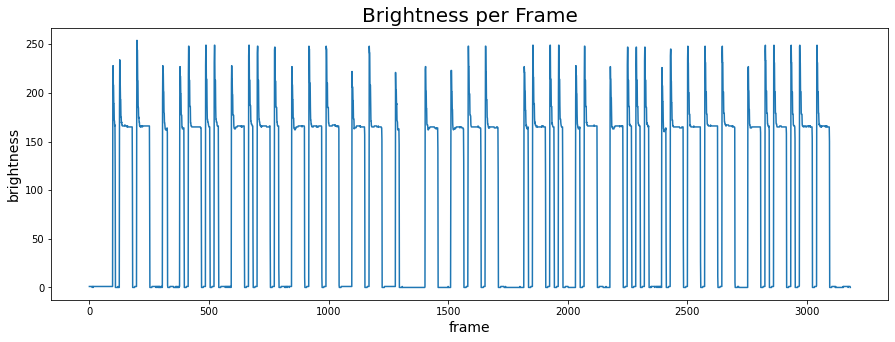

dark 98 0 -98
dark 108 0 9
dark 126 1 -17
dark 180 1 53
dark 198 2 -17
dark 252 2 53
dark 306 3 -53
dark 327 3 20
dark 378 4 -50
dark 396 4 17
dark 414 5 -17
dark 468 5 53
dark 486 6 -17
dark 504 6 17
dark 522 7 -17
dark 540 7 17
dark 594 8 -53
dark 648 8 53
dark 666 9 -17
dark 684 9 17
dark 702 10 -17
dark 756 10 53
dark 774 11 -17
dark 792 11 17
dark 846 12 -53
dark 900 12 53
dark 918 13 -17
dark 972 13 53
dark 990 14 -17
dark 1044 14 53
dark 1098 15 -53
dark 1152 15 53
dark 1170 16 -17
dark 1224 16 53
dark 1280 17 -55
dark 1296 17 15
dark 1404 18 -107
dark 1458 18 53
dark 1512 19 -53
dark 1565 19 52
dark 1584 20 -18
dark 1637 20 52
dark 1655 21 -17
dark 1709 21 53
dark 1817 22 -107
dark 1835 22 17
dark 1853 23 -17
dark 1907 23 53
dark 1925 24 -17
dark 1943 24 17
dark 1961 25 -17
dark 1979 25 17
dark 2033 26 -53
dark 2051 26 17
dark 2069 27 -17
dark 2123 27 53
dark 2177 28 -53
dark 2231 28 53
dark 2249 29 -17
dark 2267 29 17
dark 2285 30 -17
dark 2303 30 17
dark 2321 31 -17
dark 2339

In [46]:
run_test(0)

start converting video into images
converting video into images took 27 seconds. 
 Checkpoint 1: brightness plot


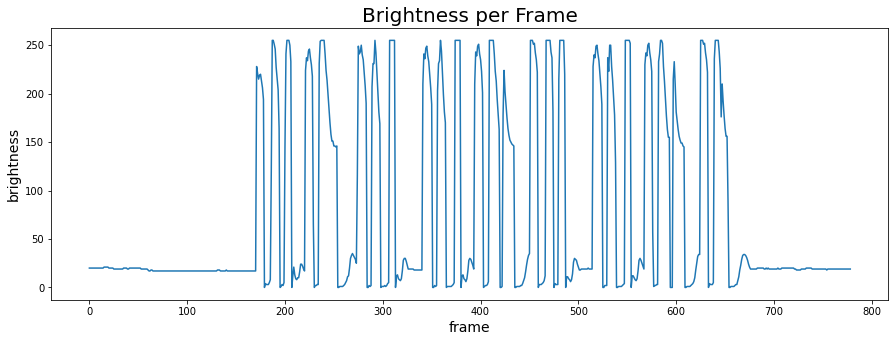

dark 171 0 -171
dark 179 0 7
dark 186 1 -6
dark 195 1 8
dark 200 2 -4
dark 207 2 6
dark 221 3 -13
dark 229 3 7
dark 235 4 -5
dark 254 4 18
dark 274 5 -19
dark 284 5 9
dark 289 6 -4
dark 298 6 8
dark 307 7 -8
dark 313 7 5
dark 341 8 -27
dark 351 8 9
dark 356 9 -4
dark 365 9 8
dark 374 10 -8
dark 380 10 5
dark 394 11 -13
dark 403 11 8
dark 409 12 -5
dark 420 12 10
dark 423 13 -2
dark 435 13 11
dark 451 14 -15
dark 459 14 7
dark 467 15 -7
dark 475 15 7
dark 480 16 -4
dark 487 16 6
dark 515 17 -27
dark 525 17 9
dark 530 18 -4
dark 539 18 8
dark 548 19 -8
dark 554 19 5
dark 568 20 -13
dark 576 20 7
dark 582 21 -5
dark 594 21 11
dark 597 22 -2
dark 609 22 11
dark 625 23 -15
dark 633 23 7
dark 639 24 -5
dark 653 24 13
Checkpoint 2: a labeled list of signal lengths is  [7, -6, 8, -4, 6, -13, 7, -5, 18, -19, 9, -4, 8, -8, 5, -27, 9, -4, 8, -8, 5, -13, 8, -5, 10, -2, 11, -15, 7, -7, 7, -4, 6, -27, 9, -4, 8, -8, 5, -13, 7, -5, 11, -2, 11, -15, 7, -5, 13] [3, 2, 3, 2, 3, 1, 3, 2, 4, 1, 3, 2, 3, 2,

In [43]:
run_test(1,100)

# it is supposed to be 27 light frame groups but we only detect 25 of them. how to handle missing light frame groups?

start converting video into images
converting video into images took 30 seconds. 
 Checkpoint 1: brightness plot


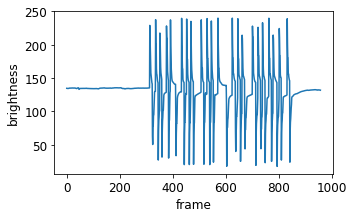

Checkpoint 2: a labeled list of signal lengths is  [9, -11, 9, -5, 7, -16, 7, -6, 19, -21, 9, -8, 9, -5, 9, -28, 9, -11, 9, -5, 7, -16, 16, -36, 11, -8, 9, -5, 9, -28, 12, -7, 9, -6, 9, -13, 9, -5, 14, -7, 7, -21] [3 2 3 2 3 1 3 2 4 1 3 2 3 2 3 0 3 2 3 2 3 1 4 0 3 2 3 2 3 0 3 2 3 2 3 1 3
 2 4 2 3 1]
Checkpoint 3: The plaintext is  SAS ST S SR
Student answer is SAS ST S SR. Correct answer is SOS SOS SOS

Test 3 for video light-far : Failed


In [41]:
run_test(2,140)

start converting video into images
converting video into images took 30 seconds. 
 Checkpoint 1: brightness plot


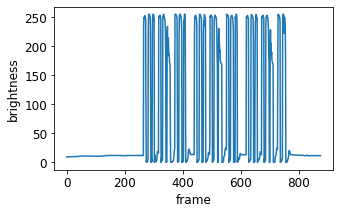

Checkpoint 2: a labeled list of signal lengths is  [7, -7, 7, -5, 6, -14, 7, -5, 10, -3, 10, -15, 7, -5, 9, -5, 6, -29, 8, -7, 8, -4, 7, -14, 7, -5, 11, -2, 11, -15, 7, -5, 9, -5, 6, -30, 7, -7, 8, -4, 7, -14, 7, -5, 11, -2, 10, -14, 8, -7] [3 2 3 2 3 1 3 2 4 2 4 1 3 2 4 2 3 0 3 2 3 2 3 1 3 2 4 2 4 1 3 2 4 2 3 0 3
 2 3 2 3 1 3 2 4 2 4 1 3 2]
Checkpoint 3: The plaintext is  SWR SWR SW
Student answer is SWR SWR SW. Correct answer is SOS SOS SOS

Test 4 for video dark-close : Failed


In [42]:
run_test(3)

start converting video into images
converting video into images took 25 seconds. 
 Checkpoint 1: brightness plot


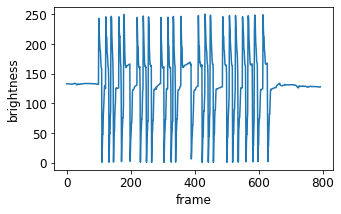

Checkpoint 2: a labeled list of signal lengths is  [9, -11, 8, -6, 6, -17, 6, -7, 19, -21, 8, -9, 8, -6, 9, -28, 9, -11, 8, -6, 6, -17, 31, -21, 11, -8, 9, -5, 9, -28, 12, -7, 9, -8, 7, -13, 9, -6, 13, -5, 9, -16] [3 2 3 2 3 1 3 2 4 1 3 2 3 2 3 0 3 2 3 2 3 1 4 1 3 2 3 2 3 0 3 2 3 2 3 1 3
 2 3 2 3 1]
Checkpoint 3: The plaintext is  SAS STS SS
Student answer is SAS STS SS. Correct answer is SOS SOS SOS

Test 5 for video light-close : Failed


In [43]:
run_test(4,140)

Evaluation metric is the number of words guessed, WORDS-GUESSED, when threshold is set at 140.


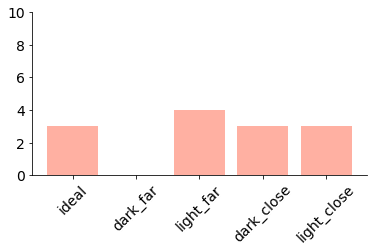

Evaluation metric is the length of longest common substring after removing spaces,  when threshold is set at 140.
SOSSOSSOS SOSSOSSOS
SOSSOSSOS 
SOSSOSSOS SASSTSSR
SOSSOSSOS SWRSWRSW
SOSSOSSOS SASSTSSS
[9, 0, 5, 3, 6]


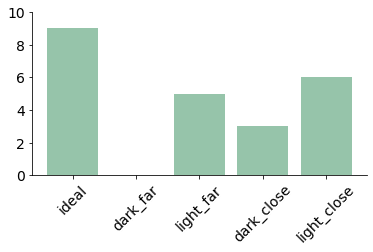

In [84]:
PLAINTEXT="SOS SOS SOS"
test_cases=['ideal', 'dark_far','light_far','dark_close','light_close']
result_plaintexts=['SOS SOS SOS','','SAS ST S SR','SWR SWR SW','SAS STS SS']
"""
Evaluation metrics:
first metric: the number of words guessed => WORDS_GUESSED
second metric: the length of longest common subbsequence after removing space characters=> LONGEST_SUBSTR_NOSPACE
"""

print("Evaluation metric is the number of words guessed, WORDS-GUESSED, when threshold is set at 140.")
WORDS_GUESSED=[]
for i in range(len(test_cases)):
    WORDS_GUESSED.append(len(result_plaintexts[i].split()))
    
fig = plt.figure(figsize=(6, 3))
plt.rcParams.update({'font.size': 14})
ax = fig.add_subplot(1,1,1)
ax.bar(test_cases,WORDS_GUESSED,color="tomato",alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False) 
plt.xticks(rotation=45)
plt.yticks([0,2,4,6,8,10])
plt.show()

def lcs(X, Y):
    m = len(X)
    n = len(Y)
    L = [[None]*(n + 1) for i in range(m + 1)]
    for i in range(m + 1):
        for j in range(n + 1):
            if i == 0 or j == 0 :
                L[i][j] = 0
            elif X[i-1] == Y[j-1]:
                L[i][j] = L[i-1][j-1]+1
            else:
                L[i][j] = max(L[i-1][j], L[i][j-1])
    return L[m][n]

print("Evaluation metric is the length of longest common substring after removing spaces,  when threshold is set at 140.")
LONGEST_SUBSTR=[]
ideal_str="".join(result_plaintexts[0].split())
for i in range(len(test_cases)):
    test_str="".join(result_plaintexts[i].split())
    print(ideal_str,test_str)
    LONGEST_SUBSTR.append(lcs(test_str,ideal_str))

print(LONGEST_SUBSTR)
fig = plt.figure(figsize=(6, 3))
plt.rcParams.update({'font.size': 14})
ax = fig.add_subplot(1,1,1)
ax.bar(test_cases,LONGEST_SUBSTR,color="seagreen",alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False) 
plt.xticks(rotation=45)
plt.yticks([0,2,4,6,8,10])
#plt.show()

start converting video into images
converting video into images took 257 seconds. 
 Checkpoint 1: brightness plot


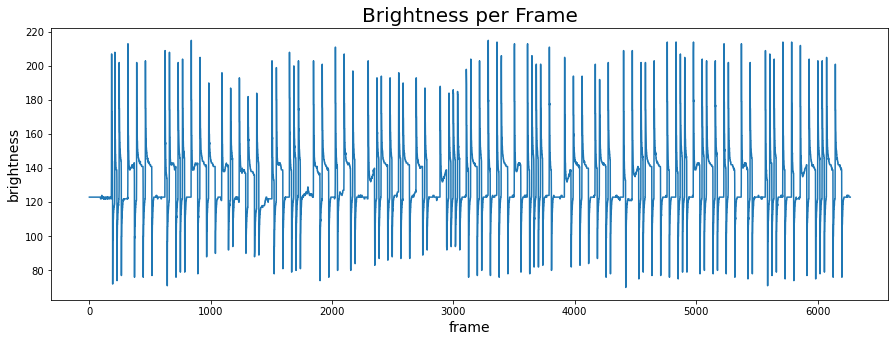

Checkpoint 2: a labeled list of signal lengths is  [7, -18, 8, -26, 16, -54, 10, -16, 14, 0, 8, -18, 52, -18, 52, -107, 7, -27, 41, -9, 1, -17, 17, -17, 17, -53, 11, -13, 27, -17, 53, -17, 53, -53, 10, -18, 23, -17, 17, -53, 12, -58, 18, -52, 17, -107, 6, -28, 38, -68, 10, -24, 17, -18, 15, -108, 24, -3, 1, -40, 36, -70, 13, 0, 1, -54, 49, -21, 16, -107, 8, -62, 17, -17, 53, -17, 17, -53, 17, -17, 53, -53, 30, -3, 0, -2, 14, -17, 17, -107, 8, -62, 17, -17, 17, -17, 17, -53, 10, -24, 52, -18, 17, -53, 11, -59, 10, -24, 52, -54, 10, -16, 24, -54, 11, -23, 16, -18, 16, -18, 16, -54, 11, -112, 8, -62, 49, 0, 1, -18, 38, -68, 12, -22, 53, -17, 17, -107, 7, -63, 9, -36, 0, -23, 17, -17, 53, -17, 52, -54, 11, -59, 9, -25, 17, -17, 17, -53, 11, -13, 26, -18, 17, -17, 52, -18, 16, -54, 13, -21, 40, -66, 12, 0, 29, -27, 16, -108, 6, -28, 16, -17, 17, -53, 11, -59, 9, -61, 9, -37, 5, -17, 40, -30, 17, -17, 17, -17, 41, -29, 42] [3, 2, 3, 2, 3, 1, 3, 2, 3, 3, 3, 2, 4, 2, 4, 0, 3, 2, 4, 2, 3, 2, 3,

TypeError: not all arguments converted during string formatting

In [50]:
student_answer = run('inputs/test-2.mov',)
print('Student answer is %s\n'%(student_answer,130))